In [2]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
%matplotlib inline 

# What is "Statistical Significance" and how do we test it?

Below is a small data set -- just seven patients -- where it *seems* that those who received a new treatment recoverer sooner.

In [3]:
experiment = Table().with_columns(
    "Patients", make_array("Control", "Control", "Control", "Treated", "Treated", "Treated", "Treated"),
    "Recovery Time (days)", make_array(22, 33, 40,19, 22, 25, 26)
)
experiment

Patients,Recovery Time (days)
Control,22
Control,33
Control,40
Treated,19
Treated,22
Treated,25
Treated,26


## Compare the means of the two groups

In [4]:
experiment.group("Patients", np.mean)

Patients,Recovery Time (days) mean
Control,31.6667
Treated,23


In [5]:
experiment.group("Patients", np.std)

Patients,Recovery Time (days) std
Control,7.4087
Treated,2.73861


## Plot the distributions

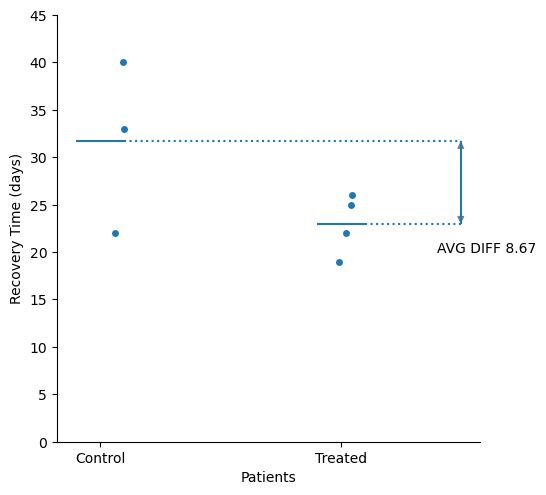

In [6]:
control_mean = 31.7
treated_mean = 23

sns.catplot(data=experiment.to_df(), x="Patients", y="Recovery Time (days)")
ax = plt.gca()
ax.set_ylim((0, 45))
ticks = ax.get_xticks()
w = 0.1
xmin, xmax = ax.get_xlim()
ax.hlines(control_mean, ticks[0]-w, ticks[0]+w)
ax.hlines(treated_mean, ticks[1]-w, ticks[1]+w)
ax.hlines(control_mean, ticks[0]+w, xmax, linestyles='dotted')
ax.hlines(treated_mean, ticks[1]+w, xmax, linestyles='dotted')
ax.vlines(xmax, treated_mean, control_mean,)
my_arrow = FancyArrowPatch(posA=(xmax, treated_mean),
                          posB=(xmax, control_mean), 
                          arrowstyle='<|-|>', color="0.5",
                          mutation_scale=10, shrinkA=0, shrinkB=0)
ax.add_artist(my_arrow)
ax.text(xmax-w, 20, "AVG DIFF 8.67")
plt.show();

It sure **seems** that the treated group recovered sooner, but there is that one annoying untreated patient who recovered just as quickly. What can we conclude? Did the treatment help?

## Hypothesis: The treatment helped patients recover more quickly.
## Null Hypothesis: The treatment did nothing.

Under the Null Hypothesis, the treatment did nothing. To test this, take our seven patients and randomly assign them to "treatment" and "control" and measure the different between the average recovery time of the two groups. We do this over and over and keep track of the differences between the averages.

We then compare difference in recovery times simulated assuming the treatment did nothing with the actual difference between the two groups.

In [7]:
experiment

Patients,Recovery Time (days)
Control,22
Control,33
Control,40
Treated,19
Treated,22
Treated,25
Treated,26


In [8]:
num_simulations = 100000
diff_means = 8.67
simulated_diffs = []
recovery = experiment.column("Recovery Time (days)")
for _ in np.arange(num_simulations):
    np.random.shuffle(recovery)
    new_diff = np.mean(recovery[:3]) - np.mean(recovery[3:])
    simulated_diffs.append(new_diff)
p_val_simulation = np.sum(np.abs(simulated_diffs) >= diff_means) / num_simulations
print(f"P-value from simulation: {p_val_simulation}")

P-value from simulation: 0.0855


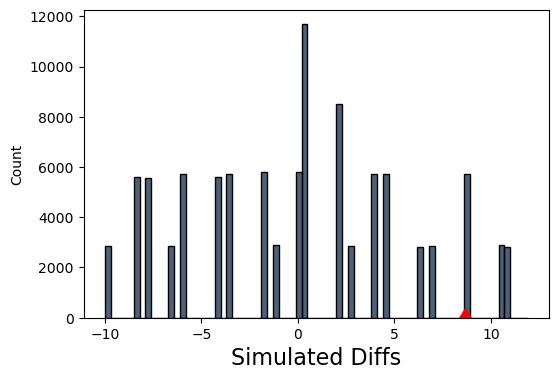

In [9]:
recovery_simulations = Table().with_columns("Simulated Diffs", simulated_diffs)
recovery_simulations.hist(bins=np.arange(-10,12,.3), density=False)
ax = plt.gca()
ax.plot(8.67, 0, 'rd', ms=10);

## What is the p-value?

The p-value is simple the probability you would see a difference as least as large as the one observed if, in truth, the treatment did nothing. That is to say, the null hypothesis is true. If this probably turns out to be very small, then we reject the null hypothesis and claim that the results of our experiement are "statistically significant."

## Our p-value was 0.085, is that small enough?
Good question! What we have found is that there is an 8.5% chance of getting our experimental result by chance, or about one chance in 12. Typically we say that p-value below 0.05 is highly likely to be significant, but we don't have real confidence in the result unless the p-value is less than 0.01, or one percent. 

## What can we conclude?
The results of our tiny experiment are suggestive, but not statistically significant. I hope you are all screaming that we need more data! This is part where you apply to NIH for another grant so you can conduct larger trials, prove your treatment works, create a start-up company, and get rich when you are acquired by big pharma. Just remember to give generously to Temple. :-)

## Postscript: Did we need to simulate?
With only seven patients, we can actully try all of the combinations directly. It turns out that there are exactly 35 ways to assign seven patients to into a groups of four and three. Consequently, we can try all of the combinations by brute force.

In [23]:
from itertools import combinations

items = list(experiment.column("Recovery Time (days)"))
mean_diffs = []

# Generate all combinations of three items
combinations_of_three = list(combinations(items, 3))

# Print each combination of three and its corresponding group of four
for i, combo_3 in enumerate(combinations_of_three):
    # Create a copy of the items list and remove the items in the current combination of three
    combo_4 = items[:]
    for item in combo_3:
        combo_4.remove(item)
    mean_diff = np.mean(combo_3) - np.mean(combo_4)
    mean_diffs.append(mean_diff)
    print(combo_3, combo_4, mean_diff)

(33, 25, 26) [40, 22, 22, 19] 2.25
(33, 25, 40) [26, 22, 22, 19] 10.4166666667
(33, 25, 22) [26, 40, 22, 19] -0.0833333333333
(33, 25, 22) [26, 40, 22, 19] -0.0833333333333
(33, 25, 19) [26, 40, 22, 22] -1.83333333333
(33, 26, 40) [25, 22, 22, 19] 11.0
(33, 26, 22) [25, 40, 22, 19] 0.5
(33, 26, 22) [25, 40, 22, 19] 0.5
(33, 26, 19) [25, 40, 22, 22] -1.25
(33, 40, 22) [25, 26, 22, 19] 8.66666666667
(33, 40, 22) [25, 26, 22, 19] 8.66666666667
(33, 40, 19) [25, 26, 22, 22] 6.91666666667
(33, 22, 22) [25, 26, 40, 19] -1.83333333333
(33, 22, 19) [25, 26, 40, 22] -3.58333333333
(33, 22, 19) [25, 26, 40, 22] -3.58333333333
(25, 26, 40) [33, 22, 22, 19] 6.33333333333
(25, 26, 22) [33, 40, 22, 19] -4.16666666667
(25, 26, 22) [33, 40, 22, 19] -4.16666666667
(25, 26, 19) [33, 40, 22, 22] -5.91666666667
(25, 40, 22) [33, 26, 22, 19] 4.0
(25, 40, 22) [33, 26, 22, 19] 4.0
(25, 40, 19) [33, 26, 22, 22] 2.25
(25, 22, 22) [33, 26, 40, 19] -6.5
(25, 22, 19) [33, 26, 40, 22] -8.25
(25, 22, 19) [33, 26, 4

In [29]:
p_val = np.sum(np.abs(mean_diffs) >= diff_means) / len(combinations_of_three)
p_val

0.085714285714285715

This is the exact p-value, without running tens of thousands of simulations. So why simulate? Well, as the experiment size grows, the number of possible combinations increases dramatically.

There were only 35 combinations of 3 and 4 out of 7 patients. We wanted to chose groups of 30 and 40 out of 70 patients the number of combinations would be huge. Let's calculate it. The equation for the number of ways you can choose k out of n items is:

$$\binom{n}{k} = \frac{n!}{k!(n-k)!}$$

This equation uses factorials. You knew they had to be good for something!

In [34]:
import math

# Combinations of 3 and 4 out of 7
math.factorial(7) / (math.factorial(3) * math.factorial(4))

35.0

In [35]:
# Combinations of 30 and 40 out of 70
math.factorial(70) / (math.factorial(30) * math.factorial(40))

5.534774005814351e+19

Yup, that is 5.5 with nineteen zeros behind it! You cannot solve this by looping over **all** possible combinations. Instead, you simulate a large number of possible combinations to get close to the exact answer.